## **Example. Stratified sampling in pre-election polling**

In [5]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd
import scipy.stats as stats
import theano.tensor as tt
import arviz
import seaborn
import time
from scipy.special import expit as logistic
from scipy.special import logit
from scipy.special import softmax

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.style.use('seaborn-darkgrid')
plt.rc('font', size=12)

%config Inline.figure_formats = ['retina']

A survey of 1447 adults.

In [6]:
participants = 1447

This is the Table 8.2

In [7]:
data = pd.read_csv('data/cbs_survey.txt', sep=' ', skiprows=2, skipinitialspace=True, index_col=False)
data

,region,density,bush,dukakis,other,proportion
0,Northeast,I,0.298,0.617,0.085,0.032
1,Northeast,II,0.500,0.478,0.022,0.032
2,Northeast,III,0.467,0.413,0.120,0.115
3,Northeast,IV,0.464,0.522,0.014,0.048
4,Midwest,I,0.404,0.489,0.106,0.032
5,Midwest,II,0.447,0.447,0.106,0.065
6,Midwest,III,0.509,0.388,0.103,0.080
7,Midwest,IV,0.552,0.338,0.110,0.100
8,South,I,0.571,0.286,0.143,0.015
9,South,II,0.469,0.406,0.125,0.066


We need the number of people of each region and each candidate.

In [8]:
data_obs = data[['bush', 'dukakis', 'other']].to_numpy()
print(data_obs)

[[0.298 0.617 0.085]
 [0.5   0.478 0.022]
 [0.467 0.413 0.12 ]
 [0.464 0.522 0.014]
 [0.404 0.489 0.106]
 [0.447 0.447 0.106]
 [0.509 0.388 0.103]
 [0.552 0.338 0.11 ]
 [0.571 0.286 0.143]
 [0.469 0.406 0.125]
 [0.515 0.404 0.081]
 [0.555 0.352 0.093]
 [0.5   0.471 0.029]
 [0.532 0.351 0.117]
 [0.54  0.371 0.089]
 [0.554 0.361 0.084]]


In [9]:
print(data_obs[:, 0] / (data_obs[:, 0] + data_obs[:, 1]), '\n')
print(1 - data_obs[:, 2])

[0.32568306 0.51124744 0.53068182 0.47058824 0.45240761 0.5
 0.56744705 0.62022472 0.66627771 0.536      0.56039173 0.61190739
 0.51493306 0.60249151 0.59275521 0.60546448] 

[0.915 0.978 0.88  0.986 0.894 0.894 0.897 0.89  0.857 0.875 0.919 0.907
 0.971 0.883 0.911 0.916]


In [10]:
proportion = data['proportion'].to_numpy() * participants
print(proportion)

[ 46.304  46.304 166.405  69.456  46.304  94.055 115.76  144.7    21.705
  95.502  98.396 182.322  33.281  76.691 124.442  82.479]


In [11]:
np.sum(proportion)

1444.106

In [12]:
print(data_obs.shape)
print(proportion.shape)

(16, 3)
(16,)


In [13]:
values = data_obs[:, :] * proportion.reshape(16, -1)
values = np.round(values)
np.sum(values)   # Check if the sum is equal to 1447

1447.0

### **Nonhierarchical model**

In [14]:
with pm.Model() as model_non_hiera:
    
    thetas = pm.Dirichlet('thetas', a=np.ones_like(data_obs), shape=(16, 3))
    post = pm.Multinomial('post', n=np.sum(values, axis=1), p=thetas, observed=values)

In [15]:
model_non_hiera.check_test_point()

thetas_stickbreaking__    -41.64
post                     -322.85
Name: Log-probability of test_point, dtype: float64

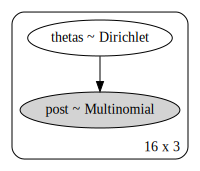

In [16]:
pm.model_to_graphviz(model_non_hiera)

In [17]:
with model_non_hiera:
    trace_1 = pm.sample(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetas]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:13<00:00, 1194.54draws/s]


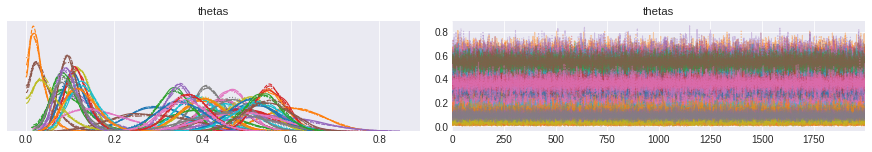

In [18]:
pm.traceplot(trace_1, var_names=['thetas']);

In [19]:
arviz.summary(trace_1)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"thetas[0,0]",0.300,0.064,0.183,0.424,0.000,0.000,20497.0,18033.0,20306.0,5485.0,1.0
"thetas[0,1]",0.600,0.068,0.469,0.724,0.000,0.000,18636.0,17860.0,18527.0,5570.0,1.0
"thetas[0,2]",0.100,0.042,0.029,0.178,0.000,0.000,16683.0,10963.0,17565.0,5671.0,1.0
"thetas[1,0]",0.490,0.071,0.357,0.621,0.000,0.000,22720.0,20814.0,22669.0,5743.0,1.0
"thetas[1,1]",0.470,0.071,0.342,0.604,0.000,0.000,20246.0,19174.0,20256.0,5921.0,1.0
"thetas[1,2]",0.041,0.028,0.001,0.091,0.000,0.000,14038.0,8686.0,13641.0,5593.0,1.0
"thetas[2,0]",0.465,0.038,0.392,0.533,0.000,0.000,19496.0,19331.0,19518.0,5376.0,1.0
"thetas[2,1]",0.412,0.037,0.344,0.484,0.000,0.000,17488.0,17011.0,17509.0,5936.0,1.0
"thetas[2,2]",0.124,0.025,0.078,0.171,0.000,0.000,17151.0,15063.0,17280.0,6015.0,1.0
"thetas[3,0]",0.459,0.058,0.352,0.567,0.000,0.000,18130.0,17764.0,18085.0,5195.0,1.0


Now, the goal is to reproduce the figure 8.1 (a).

In [20]:
with model_non_hiera:
    ppc_non_hiera = pm.sample_posterior_predictive(trace_1, var_names=['thetas', 'post'])

100%|██████████| 8000/8000 [00:13<00:00, 587.66it/s]


In [21]:
ppc_non_hiera['thetas'].shape

(8000, 16, 3)

Just check if the column **proportion** (look at the data frame) is equal to what we got.

In [22]:
proportion / np.sum(proportion)

array([0.03206413, 0.03206413, 0.11523046, 0.04809619, 0.03206413,
       0.06513026, 0.08016032, 0.1002004 , 0.01503006, 0.06613226,
       0.06813627, 0.12625251, 0.02304609, 0.05310621, 0.08617234,
       0.05711423])

In [23]:
diff = []

for i in range(16):
    result = ppc_non_hiera['thetas'][:, i, 0] - ppc_non_hiera['thetas'][:, i, 1]
    diff.append(list(result))

In [24]:
diff = np.asarray(diff)
diff

array([[-0.15934847, -0.3558678 , -0.36340106, ..., -0.40914886,
        -0.13256056, -0.18882421],
       [ 0.04619461, -0.01816537, -0.09714105, ...,  0.30711543,
        -0.24122136, -0.22424189],
       [ 0.0744588 , -0.0131596 , -0.00063706, ...,  0.16045235,
        -0.05271542,  0.08162244],
       ...,
       [ 0.21968616,  0.20546796,  0.01871482, ...,  0.24882987,
         0.10857277,  0.16821664],
       [ 0.16953651,  0.16044884,  0.28627215, ...,  0.19292837,
         0.09478497,  0.04568657],
       [ 0.17530829,  0.20666844,  0.11741038, ...,  0.22721735,
         0.26367063,  0.18835987]])

In [25]:
result = np.sum(diff.T * proportion / np.sum(proportion), axis=1)

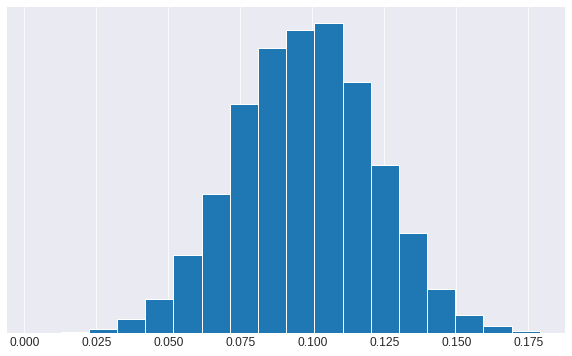

In [26]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(result, bins=18, edgecolor='w', density=True)
plt.yticks([]);

The figure is almost the same!

### **Hierarchichal model**

The authors are using other parameters, so we need to find the number of people for $\alpha_{1j}$ and $\alpha_{2j}$.

In [27]:
alpha_2j = np.round((1 - data['other'].to_numpy()) * proportion) #Not a probability as you may see
print(alpha_2j)

[ 42.  45. 146.  68.  41.  84. 104. 129.  19.  84.  90. 165.  32.  68.
 113.  76.]


In [28]:
alpha_1j = values[:, 0] / (values[:, 0] + values[:, 1]) * proportion #Not a probability as you may see
print(alpha_1j)

[ 15.07572093  23.66648889  88.29653061  32.68517647  20.94704762
  47.0275      65.67153846  89.73643411  14.47        51.16178571
  55.14501099 111.60316364  17.14475758  46.24016176  73.78419469
  49.9215    ]


In [29]:
new_values = np.round(np.stack([alpha_1j, alpha_2j], axis=1))
print(new_values)

[[ 15.  42.]
 [ 24.  45.]
 [ 88. 146.]
 [ 33.  68.]
 [ 21.  41.]
 [ 47.  84.]
 [ 66. 104.]
 [ 90. 129.]
 [ 14.  19.]
 [ 51.  84.]
 [ 55.  90.]
 [112. 165.]
 [ 17.  32.]
 [ 46.  68.]
 [ 74. 113.]
 [ 50.  76.]]


In [30]:
with pm.Model() as model_hier:
    
    packed_L = pm.LKJCholeskyCov('packed_L', n=2, eta=2., sd_dist=pm.Exponential.dist(1))
    L = pm.expand_packed_triangular(2, packed_L)
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))

    mu = pm.Normal('mu', 0, 0.01, shape=2)
#     mu = pm.Uniform('mu', -0.5, 0.5, shape=2)
#     mu = pm.Normal('mu', 0., 0.01, shape=2, testval=new_values.mean(axis=0))
    beta = pm.MvNormal('beta', mu=mu, chol=L, shape=(16, 2))
    
    alpha = tt.nnet.softmax(beta)
    
#     alphas = pm.Dirichlet('alphas', a=alpha, shape=(16, 2))

    post = pm.Multinomial('post', n=np.sum(new_values, axis=1), p=alpha, observed=new_values)

In [31]:
model_hier.check_test_point()

packed_L_cholesky-cov-packed__     -1.71
mu                                  7.37
beta                              -29.41
post                             -105.64
Name: Log-probability of test_point, dtype: float64

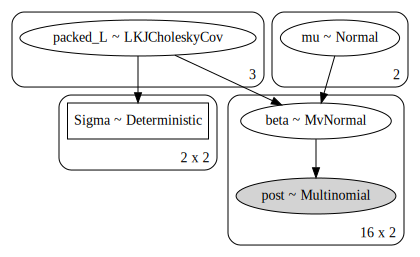

In [32]:
pm.model_to_graphviz(model_hier)

In [33]:
with model_hier:
    prior_sample = pm.sample_prior_predictive(samples=5_000)

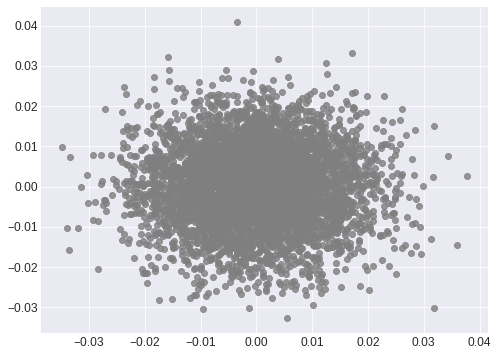

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(
    prior_sample['mu'][:, 0], 
    prior_sample['mu'][:, 1], 'o', color='C7', alpha=0.8);

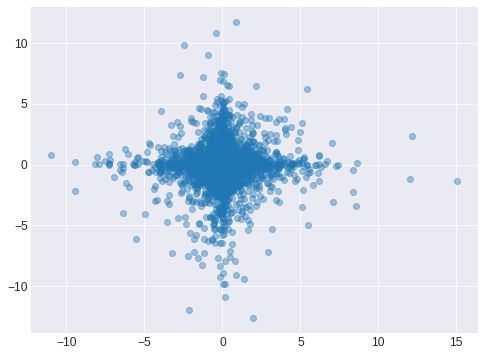

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(
    prior_sample['beta'][:, 0], 
    prior_sample['beta'][:, 1], 'o', alpha=0.4);

In [36]:
softmax(prior_sample['beta'], axis=1)[:, 0]

array([0.04234814, 0.42735343, 0.71620506, ..., 0.77613368, 0.98830831,
       0.56861496])

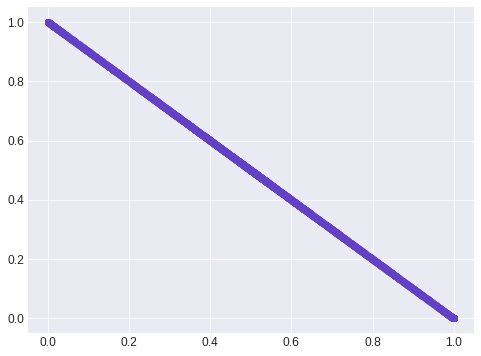

In [37]:
plt.figure(figsize=(8, 6))
plt.plot(
    softmax(prior_sample['beta'], axis=1)[:, 0],
    softmax(prior_sample['beta'], axis=1)[:, 1], 'o', color='xkcd:bluey purple', alpha=0.4);

In [39]:
with model_hier:
    trace_2 = pm.sample(draws=1_000, tune=3_000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, mu, packed_L]
Sampling 4 chains, 25 divergences: 100%|██████████| 16000/16000 [02:22<00:00, 112.56draws/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [40]:
arviz.summary(trace_2, var_names=['mu', 'beta'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],-0.003,0.010,-0.021,0.017,0.000,0.000,3533.0,1681.0,3543.0,2350.0,1.00
mu[1],0.003,0.010,-0.016,0.020,0.000,0.000,3294.0,1741.0,3281.0,2303.0,1.00
"beta[0,0]",-0.372,0.480,-1.270,0.452,0.020,0.014,565.0,565.0,523.0,1525.0,1.00
"beta[0,1]",0.433,0.483,-0.306,1.390,0.020,0.014,589.0,589.0,530.0,1442.0,1.00
"beta[1,0]",-0.236,0.379,-0.968,0.397,0.012,0.009,957.0,957.0,806.0,1425.0,1.00
"beta[1,1]",0.288,0.390,-0.347,1.037,0.012,0.009,986.0,913.0,824.0,1919.0,1.00
"beta[2,0]",-0.221,0.361,-0.945,0.406,0.012,0.009,945.0,816.0,774.0,1455.0,1.00
"beta[2,1]",0.257,0.364,-0.421,0.924,0.011,0.008,1009.0,1009.0,808.0,1342.0,1.00
"beta[3,0]",-0.292,0.409,-1.082,0.383,0.016,0.012,631.0,631.0,547.0,1321.0,1.00
"beta[3,1]",0.334,0.413,-0.392,1.090,0.016,0.012,632.0,632.0,542.0,1000.0,1.00


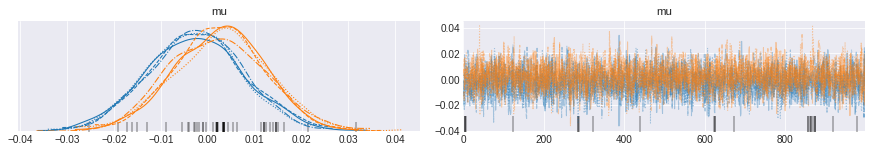

In [41]:
pm.traceplot(trace_2, var_names=['mu']);
# arviz.plot_trace(trace_2, var_names=['mu']);

If you want to check the covariance matrix

In [42]:
matrix_s = trace_2['Sigma'].mean(axis=0)

In [43]:
matrix_s

array([[0.20725225, 0.05865998],
       [0.05865998, 0.23874154]])

From that, you get $\tau_1$ and $\tau_2$

In [44]:
tau1, tau2 = np.sqrt(matrix_s[0, 0]), np.sqrt(matrix_s[1, 1])
print(tau1, tau2)

0.4552496557178931 0.48861184784694617


And then $\rho$

In [45]:
rho = matrix_s[1, 0] / (tau1 * tau2)

In [46]:
rho

0.2637110379347952

Now, the goal is to reproduce the figure 8.1 (b).

In [47]:
with model_hier:
    ppc_hier = pm.sample_posterior_predictive(trace_2, var_names=['beta'])
    
ppc_hier['beta'] = softmax(ppc_hier['beta'], axis=2)

100%|██████████| 4000/4000 [00:00<00:00, 17718.83it/s]


In [48]:
print(ppc_hier['beta'][:15, 0, :])

[[0.31347249 0.68652751]
 [0.31347249 0.68652751]
 [0.31202501 0.68797499]
 [0.25271686 0.74728314]
 [0.25271686 0.74728314]
 [0.25271686 0.74728314]
 [0.25271686 0.74728314]
 [0.25271686 0.74728314]
 [0.23952949 0.76047051]
 [0.23952949 0.76047051]
 [0.23952949 0.76047051]
 [0.23952949 0.76047051]
 [0.23952949 0.76047051]
 [0.23952949 0.76047051]
 [0.38658591 0.61341409]]


In [49]:
ppc_hier['beta'].shape

(4000, 16, 2)

Remember that from 

\begin{align}
    \alpha_{1j} &= \dfrac{\theta_{1j}}{\theta_{1j} + \theta_{2j}} \\
    \alpha_{2j} &= 1 - \theta_{3j}
\end{align}

you can get $\theta_{1j}$ and $\theta_{2j}$

In [50]:
th1 = []

for i in range(16):
    result1 =  2 * ppc_hier['beta'][:, i, 0] * ppc_hier['beta'][:, i, 1] - ppc_hier['beta'][:, i, 1] 
#     result1 = - 2 * ppc_hier['alphas'][:, i, 0] * ppc_hier['alphas'][:, i, 1] + ppc_hier['alphas'][:, i, 1] 
    th1.append(list(result1))

In [51]:
th1 = np.asarray(th1)
th1.shape
th1 = th1.T

In [52]:
th1

array([[-0.25611253, -0.04580321, -0.10527817, ..., -0.11496639,
        -0.17975151, -0.04963993],
       [-0.25611253, -0.04580321, -0.10527817, ..., -0.11496639,
        -0.17975151, -0.04963993],
       [-0.25864418, -0.0405677 , -0.10747083, ..., -0.09382378,
        -0.19880038, -0.02752137],
       ...,
       [-0.3690686 , -0.01904772, -0.10363507, ..., -0.06335896,
        -0.09953807, -0.18144236],
       [-0.14514282, -0.27759565, -0.197737  , ..., -0.11084416,
        -0.14028941, -0.03039312],
       [-0.26916063, -0.15018802, -0.07902464, ..., -0.10092275,
        -0.0680946 , -0.11604869]])

In [53]:
result2 = np.sum(th1 * proportion / np.sum(proportion), axis=1)
result2[:15]

array([-0.11283603, -0.11283603, -0.10969546, -0.1168538 , -0.1168538 ,
       -0.1168538 , -0.1168538 , -0.1168538 , -0.12290433, -0.12290433,
       -0.12290433, -0.12290433, -0.12290433, -0.12290433, -0.14458708])

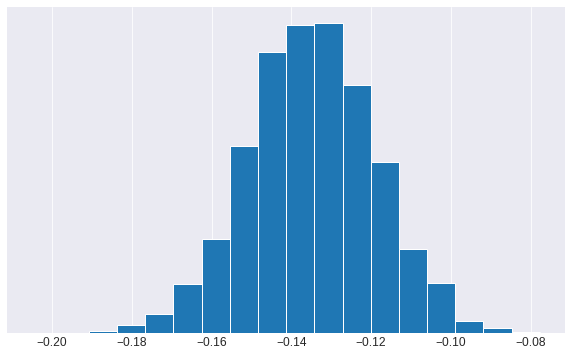

In [54]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(result2 , bins=18, edgecolor='w', density=True)
#plt.xlim(0.09, .16)
plt.yticks([]);

As you can see, the figure is quite similar, except that there is a minus sing. The next step would be the model checking, but it would be pointless (you could do it) and the results would not be right.

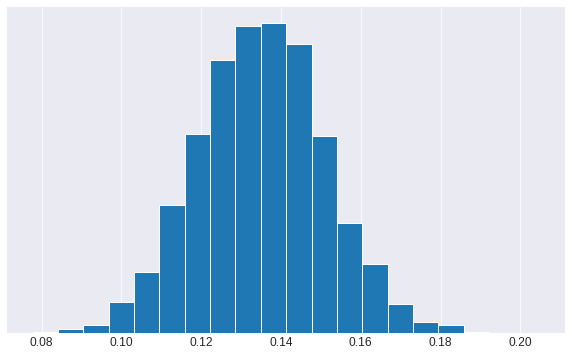

In [55]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(-result2 , bins=20, edgecolor='w', density=True) # With a minus
plt.yticks([]);

Why? I don't know, nevertheless, it is really weird.

In [56]:
%load_ext watermark

In [57]:
%watermark -iv -v -p theano,scipy,matplotlib -m

numpy   1.18.1
pymc3   3.8
arviz   0.7.0
pandas  1.0.1
seaborn 0.10.0
CPython 3.7.6
IPython 7.12.0

theano 1.0.4
scipy 1.4.1
matplotlib 3.1.3

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-91-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


## **With pystan**

This section is to reproduce the figure 8.1 (a) and the figure 8.1 (b) with Stan.

In [58]:
import pystan
print(pystan.__version__)

2.19.1.1


In [59]:
modelo="""
data {
  int<lower=0> N;
  int<lower=0> n;
  int y_obs[N, n];
  vector[n] alpha;
}

parameters {
  
  simplex[n] theta[N];
}

model {
  
  for (i in 1:N)
    theta[i] ~ dirichlet(alpha);
  
  for (i in 1:N)
    y_obs[i] ~ multinomial(theta[i]);
}

"""

In [60]:
stan_modelo = pystan.StanModel(model_code=modelo)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2a28c5090c429737936718a5aee45413 NOW.


In [61]:
print(values)

[[ 14.  29.   4.]
 [ 23.  22.   1.]
 [ 78.  69.  20.]
 [ 32.  36.   1.]
 [ 19.  23.   5.]
 [ 42.  42.  10.]
 [ 59.  45.  12.]
 [ 80.  49.  16.]
 [ 12.   6.   3.]
 [ 45.  39.  12.]
 [ 51.  40.   8.]
 [101.  64.  17.]
 [ 17.  16.   1.]
 [ 41.  27.   9.]
 [ 67.  46.  11.]
 [ 46.  30.   7.]]


In [62]:
data2 = {'N': 16,
       'n': 3,
       'alpha': [1,1,1],
       'y_obs': values.astype(int)}

In [63]:
fit = stan_modelo.sampling(data=data2)

In [64]:
print(fit.stansummary(digits_summary=3))

Inference for Stan model: anon_model_2a28c5090c429737936718a5aee45413.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
theta[1,1]    0.299 7.12e-4  0.063   0.185   0.255   0.297    0.34    0.43   7942  0.999
theta[2,1]    0.491 7.32e-4   0.07    0.35   0.444   0.491   0.538    0.63   9194    1.0
theta[3,1]    0.464 4.45e-4  0.038   0.388   0.438   0.464   0.489   0.539   7417  0.999
theta[4,1]    0.459 6.45e-4  0.058   0.346   0.421   0.459   0.498   0.573   7993    1.0
theta[5,1]      0.4 7.38e-4  0.069   0.268   0.352   0.398   0.446   0.539   8744  0.999
theta[6,1]    0.443 5.41e-4  0.049   0.351   0.408   0.442   0.476    0.54   8199  0.999
theta[7,1]    0.505  5.0e-4  0.046   0.416   0.474   0.505   0.536   0.595   8475  0.999
theta[8,1]    0.547 4.57e-4  0.041   0.467   0.519   0.547   0.575   0.627   8122    1.0
theta[9,1]

In [65]:
samples = fit.extract(permuted=True)['theta']

In [66]:
samples.shape

(4000, 16, 3)

In [67]:
samples[999, :, :]

array([[0.29572325, 0.65129841, 0.05297834],
       [0.54051595, 0.432803  , 0.02668105],
       [0.47824452, 0.35413056, 0.16762492],
       [0.51957493, 0.47637818, 0.0040469 ],
       [0.40854686, 0.41944028, 0.17201286],
       [0.38775786, 0.48608583, 0.1261563 ],
       [0.52421906, 0.36840217, 0.10737878],
       [0.51847677, 0.337041  , 0.14448223],
       [0.40462137, 0.5052229 , 0.09015573],
       [0.51062115, 0.35267396, 0.13670489],
       [0.59024591, 0.35611482, 0.05363928],
       [0.61836461, 0.29295664, 0.08867874],
       [0.36347457, 0.59558058, 0.04094485],
       [0.55051669, 0.3298886 , 0.11959471],
       [0.49178011, 0.40013566, 0.10808424],
       [0.56625645, 0.3640529 , 0.06969065]])

In [68]:
np.mean(samples[:, 0, 2])

0.10019345338843164

In [69]:
diff3 = []

for i in range(16):
    result3 = samples[:, i, 0] - samples[:, i, 1]
    diff3.append(list(result3))

In [70]:
diff3 = np.asarray(diff3)
diff3

array([[-0.37379623, -0.40020554, -0.35526723, ..., -0.45095156,
        -0.14461942, -0.40179938],
       [ 0.04206939, -0.09303923, -0.09644825, ...,  0.18600798,
         0.15895143,  0.112105  ],
       [-0.08043822,  0.05722378, -0.04404239, ...,  0.0013293 ,
         0.02855459,  0.13559384],
       ...,
       [-0.01346588,  0.12558811,  0.0464158 , ...,  0.0514563 ,
         0.14019075,  0.22758187],
       [ 0.25544295,  0.18122796,  0.21108366, ...,  0.06446671,
         0.34555547,  0.11465078],
       [ 0.14040905,  0.15922342,  0.09676584, ...,  0.05328776,
        -0.05423725,  0.3145302 ]])

In [71]:
diff3.T[300, :]

array([-0.40828455,  0.22569834,  0.0602826 ,  0.07930029,  0.00955351,
       -0.04819828,  0.00276351,  0.21396297,  0.23868738,  0.03966128,
        0.29747492,  0.17296242, -0.09768944,  0.13778526,  0.13535163,
        0.39908791])

In [72]:
proportion / np.sum(proportion)

array([0.03206413, 0.03206413, 0.11523046, 0.04809619, 0.03206413,
       0.06513026, 0.08016032, 0.1002004 , 0.01503006, 0.06613226,
       0.06813627, 0.12625251, 0.02304609, 0.05310621, 0.08617234,
       0.05711423])

In [73]:
ii = 3989
print(diff3.T[ii, :] * proportion / np.sum(proportion))
np.sum(diff3.T[ii, :] * proportion / np.sum(proportion))

[-0.00903626  0.00915508  0.00813136  0.00217919 -0.0036359   0.00712706
 -0.00098481  0.01602406 -0.00069021  0.01149549 -0.00577915  0.0293123
  0.00473389 -0.00404456  0.00639422  0.01363429]


0.0840160462208799

In [74]:
res2 = np.sum(diff3.T * proportion / np.sum(proportion), axis=1)

In [75]:
res2.shape

(4000,)

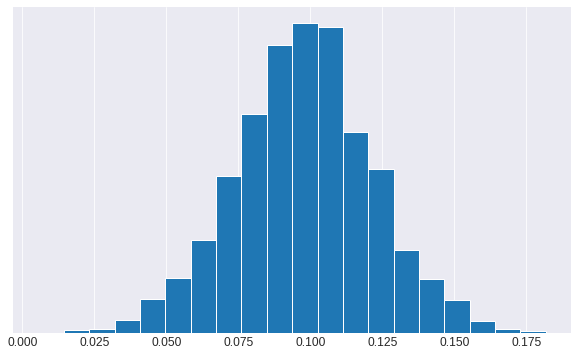

In [76]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(res2, bins=20, edgecolor='w', density=True)
plt.yticks([]);
# plt.savefig('model_non_hier.png', dpi=120)

With this, the figure 8.1 (a) is very similiar to this one.

### **Pystan with the hierarchical model**

In [78]:
modelo2 = """
data {
  int<lower=0> N;
  int<lower=0> n;
  int post[N, n];
}

parameters {
  vector[n] mu;
  cholesky_factor_corr[n] L;
  vector[n] beta[N];
    
}

transformed parameters{
  vector[n] theta[N] ;
  
  for (i in 1:N)
    theta[i] = inv_logit(beta[i]);
     
}

model {

  L ~ lkj_corr_cholesky(3.0);
 
  mu ~ exponential(0.01);
  
  beta ~ multi_normal_cholesky(mu, L);
  
    
  for (i in 1:N)
    post[i] ~ multinomial(theta[i]);
  
}

generated quantities {

  corr_matrix[n] Sigma;
  Sigma = multiply_lower_tri_self_transpose(L);
  
}


"""

modelo3 = """
data {
  int<lower=0> N;
  int<lower=0> n;
  int post[N, n];
}

parameters {
  vector[n] mu;
  cholesky_factor_corr[n] L;
  vector[n] beta[N];
  
}

transformed parameters{
  
  vector<lower=0, upper=1>[n] alphas[N];
  
  
  for (i in 1:N)
    alphas[i] = softmax(beta[i]);
   
}

model {

  L ~ lkj_corr_cholesky(3.0);
 
  mu ~ normal(0, 0.01);
  
  beta ~ multi_normal_cholesky(mu, L);
    
  for (i in 1:N)
    post[i] ~ multinomial(alphas[i]);
  
}

generated quantities {

  corr_matrix[n] Sigma;
  Sigma = multiply_lower_tri_self_transpose(L);
  
}

 
"""

In [79]:
stan_modelo2 = pystan.StanModel(model_code=modelo2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_484b7371ef716b8699f231237da781fc NOW.


In [80]:
new_values

array([[ 15.,  42.],
       [ 24.,  45.],
       [ 88., 146.],
       [ 33.,  68.],
       [ 21.,  41.],
       [ 47.,  84.],
       [ 66., 104.],
       [ 90., 129.],
       [ 14.,  19.],
       [ 51.,  84.],
       [ 55.,  90.],
       [112., 165.],
       [ 17.,  32.],
       [ 46.,  68.],
       [ 74., 113.],
       [ 50.,  76.]])

In [81]:
data3 = {'N': 16,
         'n': 2,
         'post': new_values.astype(int)}

In [82]:
fit2 = stan_modelo2.sampling(data=data3, iter=5000, verbose=True, control={'adapt_delta':0.90}, init=0)

In [83]:
print(fit2.stansummary(digits_summary=3))

Inference for Stan model: anon_model_484b7371ef716b8699f231237da781fc.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                 mean  se_mean       sd     2.5%      25%      50%      75%   97.5%  n_eff   Rhat
mu[1]         1.48e-7   5.6e-8  8.74e-8  2.09e-9   7.3e-8   1.6e-7   2.1e-7 2.96e-7      2  3.366
mu[2]         1.08e-7  2.67e-8  6.65e-8  1.62e-8  6.79e-8  9.65e-8  1.37e-7 3.05e-7      6  2.052
L[1,1]            1.0      nan      0.0      1.0      1.0      1.0      1.0     1.0    nan    nan
L[2,1]       -7.12e-9  6.09e-8  9.36e-8 -1.67e-7 -7.13e-8 -9.13e-9  6.09e-8  1.6e-7      2  4.265
L[1,2]            0.0      nan      0.0      0.0      0.0      0.0      0.0     0.0    nan    nan
L[2,2]            1.0  2.5e-15 4.65e-15      1.0      1.0      1.0      1.0     1.0      3    1.3
beta[1,1]     3.65e-8  4.45e-8  7.19e-8 -9.88e-8  -2.4e-8  4.06e-8  8.73e-8 1.81e-7      3  2.902
beta[2,1]     9.35e-9  4.8

In [ ]:
samples2 = fit2.extract(permuted=True)['beta']

In [ ]:
samples2 = softmax(samples2, axis=2)

In [ ]:
samples2[:10, 4, :]

In [ ]:
th5 = []

for i in range(16):
    res5 =  2 * samples2[:, i, 0] * samples2[:, i, 1] - samples2[:, i, 1] 
#     result1 = - 2 * ppc_hier['alphas'][:, i, 0] * ppc_hier['alphas'][:, i, 1] + ppc_hier['alphas'][:, i, 1] 
    th5.append(list(res5))

In [ ]:
th5 = np.asarray(th5)
th5.shape

In [ ]:
th5

In [ ]:
result5 = np.sum(th5.T * proportion / np.sum(proportion), axis=1)
print(result5.shape)
result5[:15]

In [ ]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(result5 , bins=20, edgecolor='w', density=True)
plt.yticks([]);
# plt.savefig('model_hier.png', dpi=120)

Again, very similar to the figure 8.1 (b), except for a minus sign. Why? It is not clear at the moment.